In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models, applications, callbacks
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr, mean_squared_error as mse

2025-12-17 08:27:43.526447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765960063.693478      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765960063.747006      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765960064.152904      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765960064.152944      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765960064.152947      24 computation_placer.cc:177] computation placer alr

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

CONFIG = {
    "TOTAL_IMAGES": 20000,
    "NUM_TRAIN": 18000,
    "NUM_TEST": 2000,
    "IMG_SIZE": 128,
    "BATCH_SIZE": 16,
    "EPOCHS_WARMUP": 10,
    "EPOCHS_FINETUNE": 30,
    "LEARNING_RATE": 1e-4,
    "PROJECT_DIR": "./working_vgg_attention_ae_32x32",
    "USE_AUGMENTATION": True,
    "USE_ATTENTION": True,
}

if not os.path.exists(CONFIG["PROJECT_DIR"]):
    os.makedirs(CONFIG["PROJECT_DIR"])

In [3]:
ds_full = tfds.load('cats_vs_dogs', split='train', as_supervised=True)
ds_full = ds_full.take(CONFIG['TOTAL_IMAGES'])

ds_train = ds_full.take(CONFIG['NUM_TRAIN'])
ds_val = ds_full.skip(CONFIG['NUM_TRAIN'])

def preprocess(image, label):
    image = tf.image.resize(image, [CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']])
    image = tf.cast(image, tf.float32) / 255.0
    return image, image

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

I0000 00:00:1765960085.582756      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.0PABIS_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [4]:
val_images = []
val_labels = []
for img, lbl in ds_val:
    resized_img = tf.image.resize(img, [CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']])
    val_images.append(resized_img.numpy())
    val_labels.append(lbl.numpy())

X_test = np.array(val_images)
y_test = np.array(val_labels).reshape(-1, 1)
X_test_normalized = X_test.astype('float32') / 255.0

train_ds = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
if CONFIG['USE_AUGMENTATION']:
    train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).batch(CONFIG["BATCH_SIZE"]).prefetch(tf.data.AUTOTUNE)

test_ds = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(CONFIG["BATCH_SIZE"]).prefetch(tf.data.AUTOTUNE)

In [5]:
class SpatialAttention(layers.Layer):
    def __init__(self, channels, reduction=8, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.channels = channels
        self.reduction = reduction
        self.query_conv = layers.Conv2D(channels // reduction, 1, name='query')
        self.key_conv = layers.Conv2D(channels // reduction, 1, name='key')
        self.value_conv = layers.Conv2D(channels, 1, name='value')
        self.gamma = self.add_weight(name='gamma', shape=(), initializer='zeros', trainable=True)
    
    def call(self, x):
        batch_size = tf.shape(x)[0]
        height = tf.shape(x)[1]
        width = tf.shape(x)[2]
        
        query = self.query_conv(x)
        key = self.key_conv(x)
        value = self.value_conv(x)
        
        query = tf.reshape(query, [batch_size, height * width, self.channels // self.reduction])
        key = tf.reshape(key, [batch_size, height * width, self.channels // self.reduction])
        value = tf.reshape(value, [batch_size, height * width, self.channels])
        
        attention_logits = tf.matmul(query, key, transpose_b=True)
        scale = tf.cast(self.channels // self.reduction, tf.float32)
        attention_logits = attention_logits / tf.sqrt(scale)
        attention_weights = tf.nn.softmax(attention_logits, axis=-1)
        
        out = tf.matmul(attention_weights, value)
        out = tf.reshape(out, [batch_size, height, width, self.channels])
        
        return x + self.gamma * out
    
    def get_config(self):
        config = super().get_config()
        config.update({'channels': self.channels, 'reduction': self.reduction})
        return config


class SSIMPSNRCallback(callbacks.Callback):
    def __init__(self, validation_data, sample_size=200):
        super().__init__()
        self.validation_data = validation_data
        self.sample_size = min(sample_size, len(validation_data))
        self.ssim_history = []
        self.psnr_history = []
    
    def on_epoch_end(self, epoch, logs=None):
        indices = np.random.choice(len(self.validation_data), self.sample_size, replace=False)
        sample_images = self.validation_data[indices]
        predictions = self.model.predict(sample_images, verbose=0)
        
        ssim_scores = []
        psnr_scores = []
        for i in range(len(sample_images)):
            s = ssim(sample_images[i], predictions[i], channel_axis=2, data_range=1.0)
            p = psnr(sample_images[i], predictions[i], data_range=1.0)
            ssim_scores.append(s)
            psnr_scores.append(p)
        
        avg_ssim = np.mean(ssim_scores)
        avg_psnr = np.mean(psnr_scores)
        
        self.ssim_history.append(avg_ssim)
        self.psnr_history.append(avg_psnr)
        
        print(f" - SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.2f} dB", end='')

In [6]:
def simple_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.7 * mse + 0.2 * mae + 0.1 * ssim_loss

def build_model(mode='warmup'):
    input_img = layers.Input(shape=(128, 128, 3), name='input_img')    
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    
    if CONFIG['USE_ATTENTION']:
        x = SpatialAttention(channels=64)(x)

    encoded = layers.MaxPooling2D((2, 2), padding='same')(x) 
    
    encoder = models.Model(input_img, encoded, name='encoder')

    decoder_input = layers.Input(shape=(32, 32, 64), name='decoder_input') 
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(decoder_input)
    x = layers.UpSampling2D((2, 2))(x)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    decoder = models.Model(decoder_input, decoded, name='decoder')
    
    autoencoder_input = input_img
    autoencoder_output = decoder(encoder(autoencoder_input))
    autoencoder = models.Model(autoencoder_input, autoencoder_output, name='autoencoder')
    
    return autoencoder

In [7]:
import time
import gc
start_time = time.time()

model = build_model(mode='warmup')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']), loss=simple_loss)
history_warmup = model.fit(train_ds, epochs=CONFIG['EPOCHS_WARMUP'], validation_data=test_ds, verbose=1)

temp_weights = os.path.join(CONFIG["PROJECT_DIR"], "warmup_weights.weights.h5")
model.save_weights(temp_weights)

del model
gc.collect()
tf.keras.backend.clear_session()

model = build_model(mode='finetune')
model.load_weights(temp_weights)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss=simple_loss)

ckpt_path = os.path.join(CONFIG["PROJECT_DIR"], "best_model_attention.keras")
ssim_psnr_callback = SSIMPSNRCallback(X_test_normalized, sample_size=200)
callbacks_list = [
    ssim_psnr_callback,
    callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

history = model.fit(train_ds, epochs=CONFIG['EPOCHS_FINETUNE'], validation_data=test_ds, callbacks=callbacks_list, verbose=1)

autoencoder = keras.models.load_model(ckpt_path, custom_objects={'simple_loss': simple_loss, 'SpatialAttention': SpatialAttention})
elapsed = (time.time() - start_time) / 60

Epoch 1/10


I0000 00:00:1765960162.187702      68 service.cc:152] XLA service 0x788a7d19a6a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765960162.187745      68 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765960162.804765      68 cuda_dnn.cc:529] Loaded cuDNN version 91002


   3/1125 ━━━━━━━━━━━━━━━━━━━━ 1:11 63ms/step - loss: 0.1682

I0000 00:00:1765960167.796093      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 90s 71ms/step - loss: 0.1276 - val_loss: 0.0539
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 77s 68ms/step - loss: 0.1091 - val_loss: 0.0492
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 76s 68ms/step - loss: 0.1078 - val_loss: 0.0477
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 76s 68ms/step - loss: 0.1069 - val_loss: 0.0459
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 76s 68ms/step - loss: 0.1060 - val_loss: 0.0458
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 76s 68ms/step - loss: 0.1058 - val_loss: 0.0467
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 76s 68ms/step - loss: 0.1054 - val_loss: 0.0432
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 76s 68ms/step - loss: 0.1050 - val_loss: 0.0422
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 76s 68ms/step - loss: 0.1045 - val_loss: 0.0420
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 77s 68ms/step - loss: 0.1046 - val_loss: 0.0414
Epoch 1/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1036 - SSIM: 0.7687, PSNR: 23.10 dB
Epoch 1: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'spatial_attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [8]:
test_predictions = autoencoder.predict(X_test_normalized, batch_size=16, verbose=0)

ssim_all = []
psnr_all = []
mse_all = []
for i in range(len(X_test_normalized)):
    ssim_score = ssim(X_test_normalized[i], test_predictions[i], channel_axis=2, data_range=1.0)
    psnr_score = psnr(X_test_normalized[i], test_predictions[i], data_range=1.0)
    mse_score = mse(X_test_normalized[i], test_predictions[i])
    ssim_all.append(ssim_score)
    psnr_all.append(psnr_score)
    mse_all.append(mse_score)

ssim_all = np.array(ssim_all)
psnr_all = np.array(psnr_all)
mse_all = np.array(mse_all)
class_names = ['Cat', 'Dog']

ssim_by_class = {}
psnr_by_class = {}
mse_by_class = {}
for class_idx in range(2):
    mask = (y_test.flatten() == class_idx)
    ssim_by_class[class_idx] = ssim_all[mask]
    psnr_by_class[class_idx] = psnr_all[mask]
    mse_by_class[class_idx] = mse_all[mask]

excellent_ssim = np.sum(ssim_all >= 0.85)
excellent_psnr = np.sum(psnr_all >= 30)
correlation = np.corrcoef(ssim_all, psnr_all)[0, 1]

print(f"Average SSIM: {np.mean(ssim_all):.4f}")
print(f"Average PSNR: {np.mean(psnr_all):.2f} dB")
print(f"Average MSE: {np.mean(mse_all):.6f}")
print(f"Training time: {elapsed:.1f} minutes")

Average SSIM: 0.7669
Average PSNR: 23.18 dB
Average MSE: 0.005537
Training time: 36.4 minutes


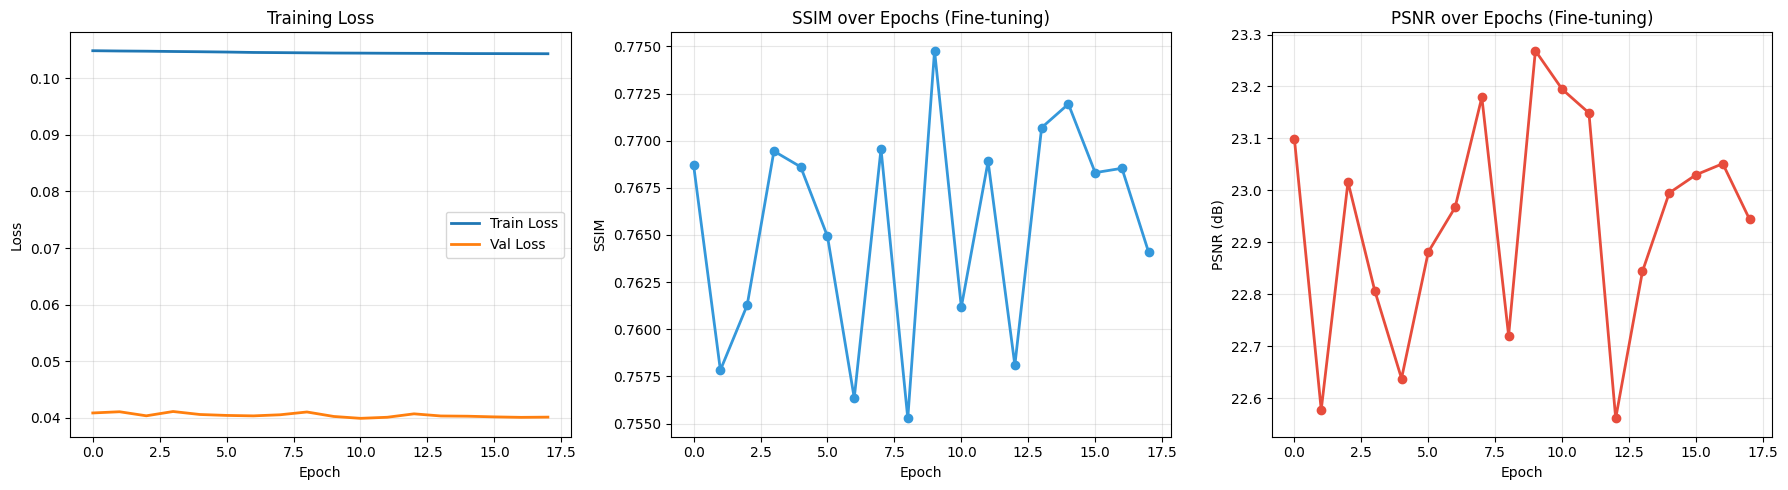

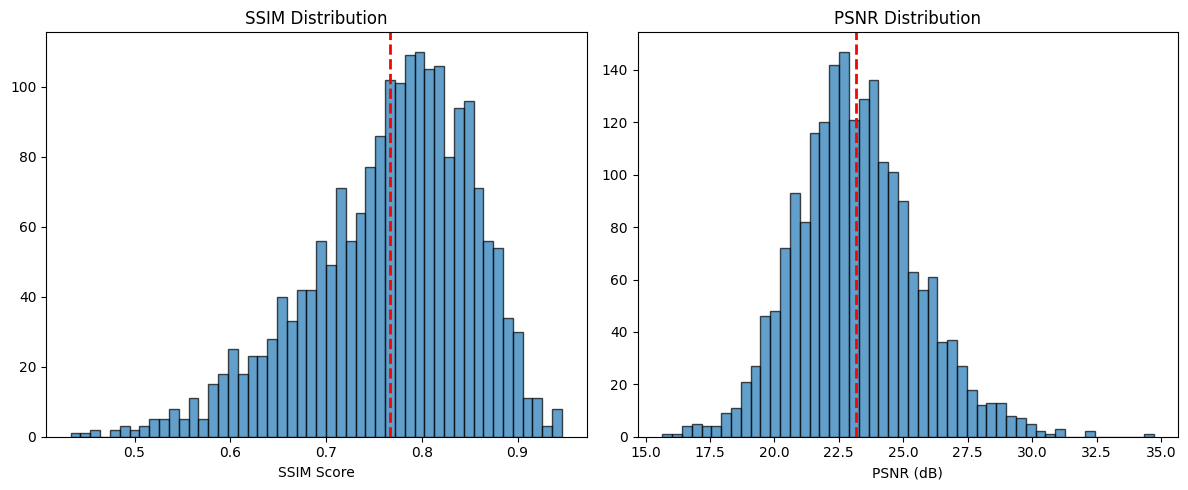

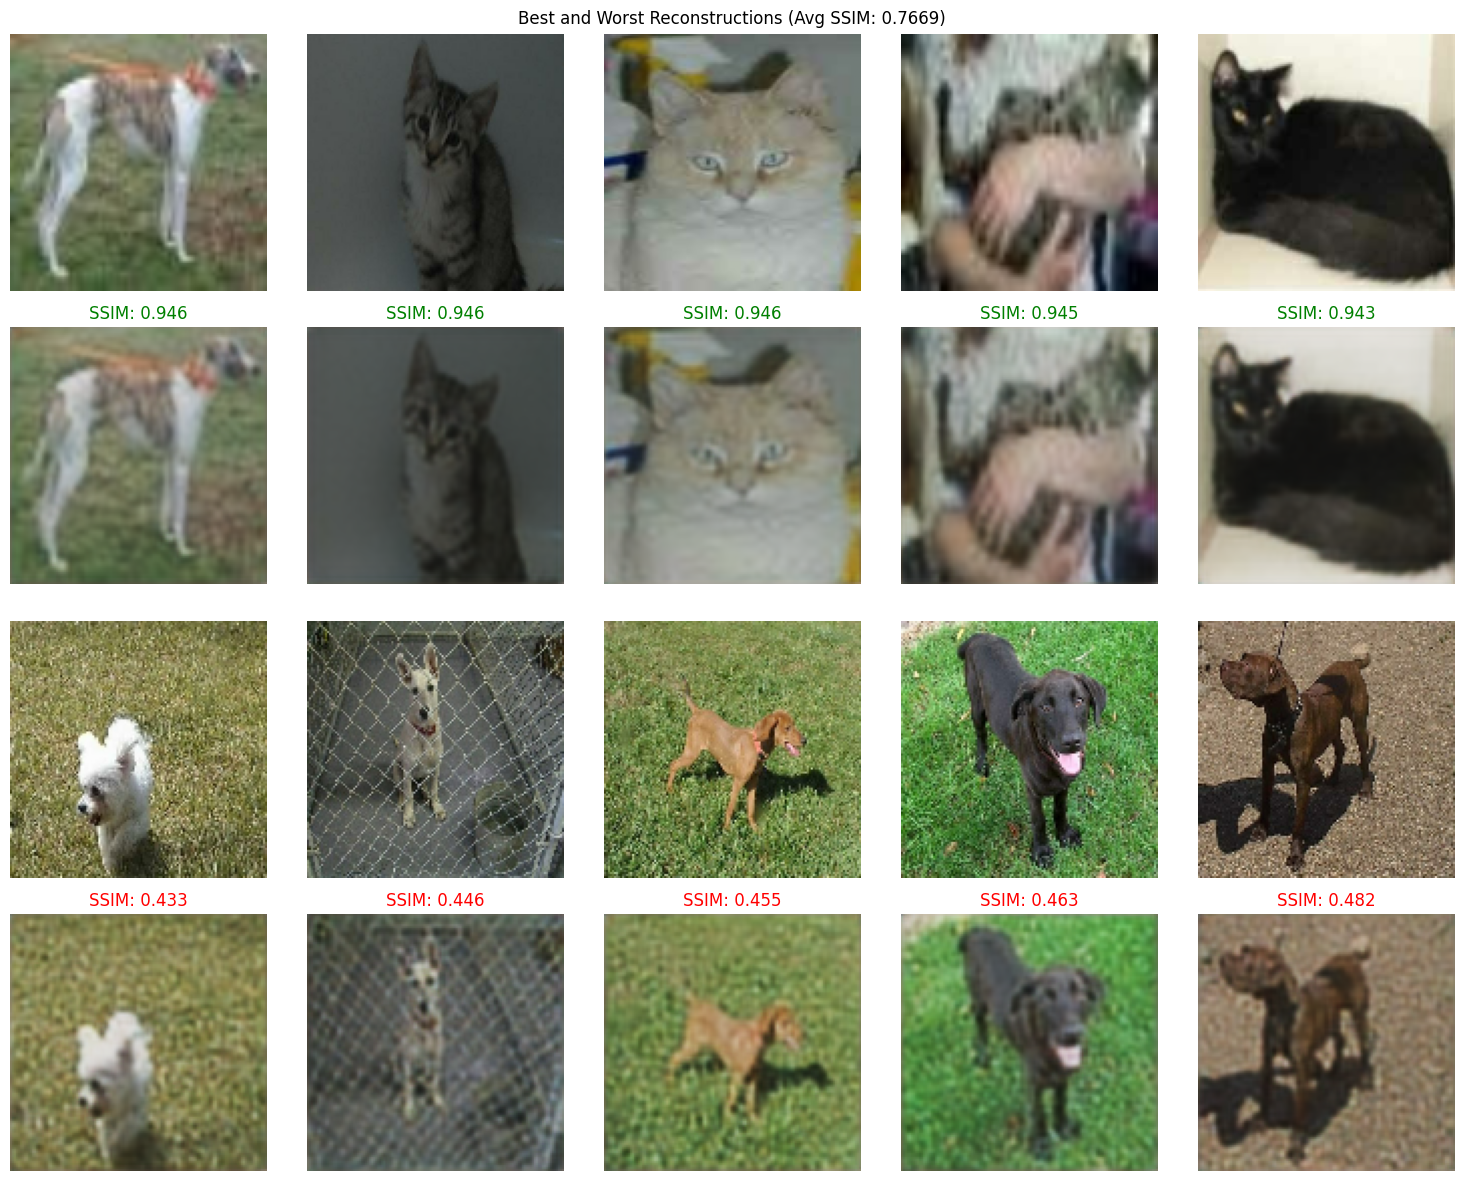

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(ssim_psnr_callback.ssim_history, linewidth=2, color='#3498db', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('SSIM')
axes[1].set_title('SSIM over Epochs (Fine-tuning)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(ssim_psnr_callback.psnr_history, linewidth=2, color='#e74c3c', marker='o')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('PSNR (dB)')
axes[2].set_title('PSNR over Epochs (Fine-tuning)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(ssim_all, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(ssim_all), color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('SSIM Score')
axes[0].set_title('SSIM Distribution')

axes[1].hist(psnr_all, bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(psnr_all), color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('PSNR (dB)')
axes[1].set_title('PSNR Distribution')
plt.tight_layout()
plt.show()

best_idx = np.argsort(ssim_all)[-5:][::-1]
worst_idx = np.argsort(ssim_all)[:5]

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, idx in enumerate(best_idx):
    axes[0, i].imshow(X_test_normalized[idx])
    axes[0, i].axis('off')
    axes[1, i].imshow(test_predictions[idx])
    axes[1, i].set_title(f'SSIM: {ssim_all[idx]:.3f}', color='green')
    axes[1, i].axis('off')

for i, idx in enumerate(worst_idx):
    axes[2, i].imshow(X_test_normalized[idx])
    axes[2, i].axis('off')
    axes[3, i].imshow(test_predictions[idx])
    axes[3, i].set_title(f'SSIM: {ssim_all[idx]:.3f}', color='red')
    axes[3, i].axis('off')

plt.suptitle(f'Best and Worst Reconstructions (Avg SSIM: {np.mean(ssim_all):.4f})')
plt.tight_layout()
plt.show()

In [10]:
print(f"\n{'='*70}")
print(f"\nFINAL RESULTS:")
print(f"   Average SSIM: {np.mean(ssim_all):.4f}")
print(f"   Average PSNR: {np.mean(psnr_all):.2f} dB")
print(f"   Average MSE: {np.mean(mse_all):.6f}")
print(f"   Excellent images (≥0.85): {excellent_ssim} ({excellent_ssim/len(ssim_all)*100:.1f}%)")
print(f"   Training time: {elapsed:.1f} minutes ({elapsed/60:.2f} hours)")



FINAL RESULTS:
   Average SSIM: 0.7669
   Average PSNR: 23.18 dB
   Average MSE: 0.005537
   Excellent images (≥0.85): 310 (15.5%)
   Training time: 36.4 minutes (0.61 hours)
